# 【1章】グラフ理論入門
以下のコードを一部引用しています。
- https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter01/01_Introduction_Networkx.ipynb

## 準備

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd

In [2]:
def draw_graph(G, pos_nodes, node_names={}, node_size=500, plot_weight=False):
    nx.draw(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    if plot_weight:
        pos_attrs = {}
        for node, coords in pos_nodes.items():
            pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
        nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
        edge_labels=dict([((a,b,),d["weight"]) for a,b,d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos_nodes, edge_labels=edge_labels)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])

## グラフの種類

### Undirected graph (無向グラフ)

In [3]:
G = nx.Graph()
V = {'Dublin', 'Paris', 'Milan', 'Rome'}
E = [('Milan','Dublin'), ('Milan','Paris'), ('Paris','Dublin'), ('Milan','Rome')]
G.add_nodes_from(V)
G.add_edges_from(E)

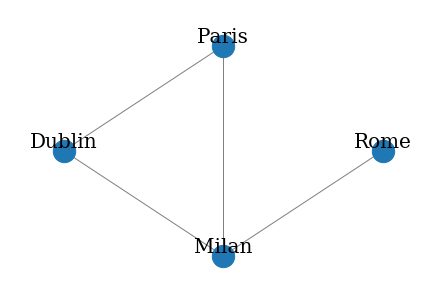

In [4]:
draw_graph(G, pos_nodes=nx.shell_layout(G))

- Graph order (ノードの数): 4
- Graph size (エッジの数): 4
- Degree for nodes (各ノードの次数): Mailan:3, Paris:2, ...

### Directed Graph (有向グラフ)

In [5]:
G = nx.DiGraph()
V = {'Dublin', 'Paris', 'Milan', 'Rome'}
E = [('Milan','Dublin'), ('Paris','Milan'), ('Paris','Dublin'), ('Milan','Rome')]
G.add_nodes_from(V)
G.add_edges_from(E)

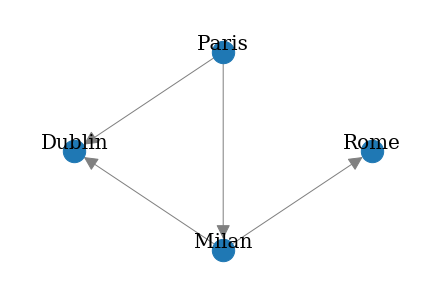

In [6]:
draw_graph(G, pos_nodes=nx.shell_layout(G))

- Indegree for nodes (各ノードの入次数): Mailan: 1, Paris: 0, ...
- Outegree for nodes （各ノードの出次数）: Mailan: 2, Paris: 2, ...

### Multi Graph (多重グラフ)

In [7]:
G = nx.MultiDiGraph()
V = {'Dublin', 'Paris', 'Milan', 'Rome'}
E = [('Milan','Dublin'), ('Milan','Dublin'), ('Paris','Milan'), ('Paris','Dublin'), ('Milan','Rome'), ('Milan','Rome')]
G.add_nodes_from(V)
G.add_edges_from(E)

[0, 1, 0, 0, 0, 1]

In [8]:
# FIXME: 公式コードのとおりだとうまく描画できない
# draw_graph(G, pos_nodes=nx.shell_layout(G))

### Weighted graphs (重み付きグラフ)

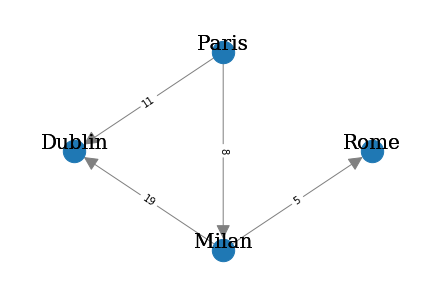

In [9]:
G = nx.MultiDiGraph()
V = {'Paris', 'Dublin','Milan', 'Rome'}
E = [ ('Paris','Dublin', 11), ('Paris','Milan', 8),
     ('Milan','Rome', 5),('Milan','Dublin', 19)]
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
draw_graph(G, pos_nodes=nx.shell_layout(G), node_size=500, plot_weight=True)

重みはコストと解釈できる。例えばParisからDublinまでのコストは11。

### Bipartite Graph (2部グラフ)

In [10]:
n_nodes = 10
n_edges = 12
bottom_nodes = [ith for ith in range(n_nodes) if ith % 2 ==0]
top_nodes = [ith for ith in range(n_nodes) if ith % 2 ==1]
iter_edges = zip(
    np.random.choice(bottom_nodes, n_edges),  
    np.random.choice(top_nodes, n_edges))
edges = pd.DataFrame([
    {"source": a, "target": b} for a, b in iter_edges])
B = nx.Graph()
B.add_nodes_from(bottom_nodes, bipartite=0)
B.add_nodes_from(top_nodes, bipartite=1)
B.add_edges_from([tuple(x) for x in edges.values])

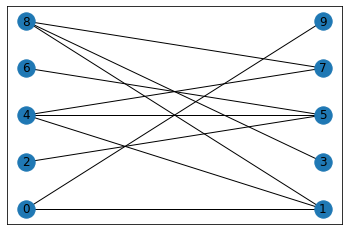

In [11]:
from networkx.drawing.layout import bipartite_layout
pos = bipartite_layout(B, bottom_nodes)
nx.draw_networkx(B, pos=pos)

## メトリクス

### Integration metrics
ノード同士がどのように相互接続されているかを定量化。

（ノード間の接続については記述できるが、グラフ内のグループのプレゼンスなどの扱いには不向き→segregation metricsを使う）

- Characteristic path length: すべてのノードペア間のshortest pathの距離(エッジ数)の平均
$$l(G) = \frac{1}{{\left| V \right|*\left( {\left| V \right| - 1} \right)}}\sum\limits_{{\upsilon \in V}} {} \sum\limits_{{\upsilon^{\prime} \in V\backslash \left\{ \upsilon \right\}}} {ShortestPathLength\left( {\upsilon,\upsilon^{\prime}} \right)}$$

（ただし、disconnected graphs(非連結グラフ)では、全てのノード間のpathを計算することができないため、このメトリックは常には定義できない→network efficiencyが広く使われる）

- Global efficiency: 全てのノードペア間のshorteset pathの逆数の平均（パスが短くなればglobal efficiencyは小さくなる）
- Local efficiency: 注目しているノードの近傍グラフ（注目ノードに隣接するノードと、ノード間を結ぶ全てのエッジで構成されるグラフ）に対してefficiencyを計算したもの

### Segregation metrics
ネットワーク内の相互接続されたノードのグループ（コミュニティやモジュール、クラスターと呼ばれる）の存在を定量化。

（グループのpresenceを理解するのに役立つ。しかし、グラフの各ノードがそれぞれ持っているimportanceを扱うには不向き→centrality metricsを使う）

- Clustering coefficient: ノードがどの程度集まっているかを示す指標。あるノードの周囲にあるtrianglesの割合。例は[wiki](https://en.wikipedia.org/wiki/Clustering_coefficient)参照。
- Transitivity: clustering coefficientの亜種。観測されたclosed tripletsの数と、可能な最大closed tripletsの数の比率
- Modularity: 相互接続性の高いノードの集合でネットワークを分割することを定量化。（他の指標と異なり、最適化アルゴリズムによって計算されることが多い。）

### Centrality metrics
ネットワーク内の個々のノードの重要性を定量化。

- Degree centrality: 任意のノードiに入射するエッジの数（ノードの次数）に直結
- Closeness centrality: 任意のノードiからグラフ内の他の全てのノードとの最短パスの長さの和の逆数（任意のノードが他のノード集合とどれぐらい近接してるかを測る）
- Betweenness centrality: あるノードが他のノードとの橋渡しの役割をどれだけ果たしているかを評価(接続が不十分なノードでも、戦略的に接続することで、ネットワーク全体の接続を維持することができるため）

### Resilience metrics
障害などの悪条件でネットワークがどの程度運用性能を維持、適応できるかを定量化。Assortativityは最もよく使われるものの1つ。

Assortativity coefficient: ノードが類似のノードに接続される傾向を定量化。計算方法は様々（例. 直接繋がったノード間の次数のPearson correlation coefficientなど）

### 実装例は以下を参照

https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter01/02_Graph_metrics.ipynb